In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import cv2
import os
import re
import math
import pandas as pd 
from pyproj import Proj, transform
import warnings
from rasterio.errors import NotGeoreferencedWarning
warnings.simplefilter("ignore", NotGeoreferencedWarning)
warnings.simplefilter("ignore", FutureWarning)
from Functions import plot


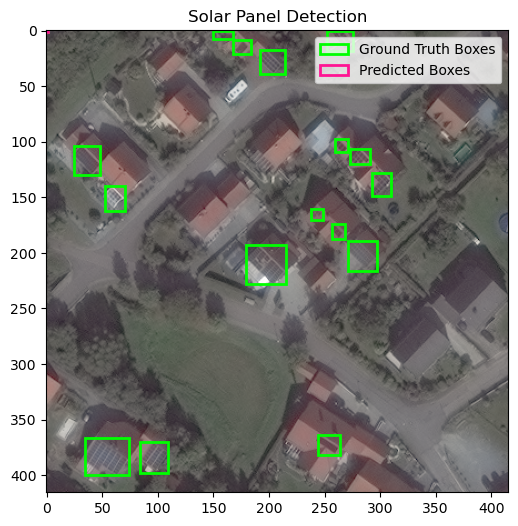

In [2]:
image_path = "dataset\image\solarpanels_native_1__x0_98_y0_7130_dxdy_416.tif"
label_path = "dataset\labels\solarpanels_native_1__x0_98_y0_7130_dxdy_416.txt"
fig, ax = plot(image_path, label_path)

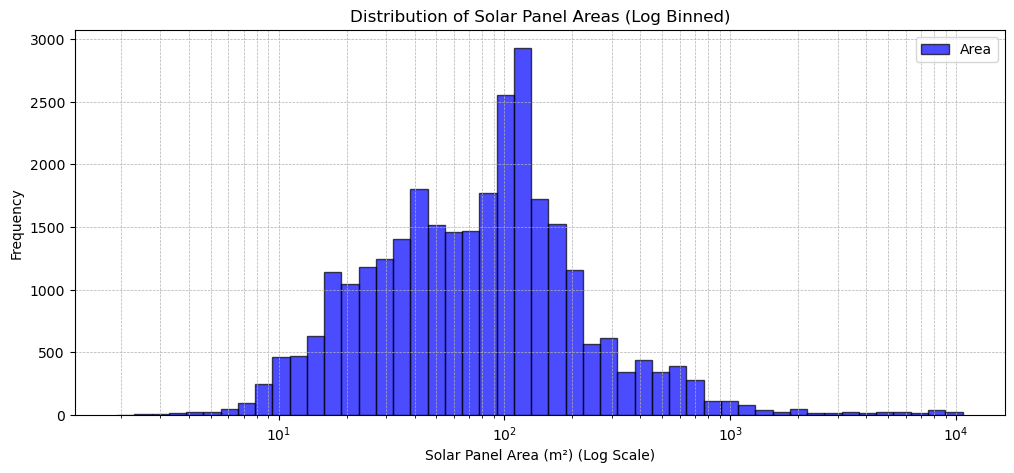

In [3]:
TILE_TRANSFORMS = {
    "1": (307670.04, 0.31, 0.0, 5434427.10, 0.0, -0.31),
    "2": (312749.08, 0.31, 0.0, 5403952.86, 0.0, -0.31),
    "3": (312749.08, 0.31, 0.0, 5363320.54, 0.0, -0.31),
}
PIXEL_SIZE = 0.31
IMAGE_SIZE = 416
FILL_FACTOR = 0.85
utm_proj = Proj("epsg:32633")
wgs84_proj = Proj("epsg:4326")

def tile(filename):
    match = re.search(r"solarpanels_native_(\d+)_", filename)
    return match.group(1) if match else None

def pixel_to_utm(x, y, tile):
    x_offset, x_scale, _, y_offset, _, y_scale = TILE_TRANSFORMS[tile]
    x_geo = x_offset + x * x_scale
    y_geo = y_offset + y * y_scale
    return x_geo, y_geo

def utm_to_latlon(x_utm, y_utm):
    lon, lat = transform(utm_proj, wgs84_proj, x_utm, y_utm)
    return lat, lon

def compute_tilt_angle(latitude):
    """M. Z. Jacobson and V. Jadhav, "World estimates of PV optimal tilt angles and ratios of sunlight
    incident upon tilted and tracked PV panels relative to horizontal panels," Department of Civil and 
    Environmental Engineering, Stanford University, 2018."""
    if latitude >= 0:
        return 1.3793 + latitude * (1.2011 + latitude * (-0.014404 + latitude * 0.000080509))
    else: 
        return -0.41657 + latitude * (1.4216 + latitude * (0.024051 + latitude * 0.00021828))

def actual_area_(width_px, height_px, latitude):
    area = (width_px * PIXEL_SIZE) * (height_px * PIXEL_SIZE)  
    tilt_angle = compute_tilt_angle(latitude)
    area_ = area * FILL_FACTOR / math.cos(math.radians(tilt_angle))  
    return area_, tilt_angle

def process_label_file(label_path, image_name):
    tile_ = tile(image_name)
    if not tile_:
        return None

    with open(label_path, "r") as f:
        lines = f.readlines()

    instances = []  
    for line in lines:
        parts = line.strip().split()
        _, x_center, y_center, width, height = map(float, parts)

        x_pixel = x_center * IMAGE_SIZE
        y_pixel = y_center * IMAGE_SIZE
        width_px = width * IMAGE_SIZE
        height_px = height * IMAGE_SIZE

        x_geo, y_geo = pixel_to_utm(x_pixel, y_pixel, tile_)
        latitude, longitude = utm_to_latlon(x_geo, y_geo)
        actual_area, tilt_angle = actual_area_(width_px, height_px, latitude)

        instances.append({
            "image_name": image_name,
            "tile": tile_,
            "latitude": latitude,
            "longitude": longitude,
            "tilt_angle": tilt_angle,
            "raw_area_m2": (width_px * PIXEL_SIZE) * (height_px * PIXEL_SIZE),
            "actual_area_m2": actual_area
        })

    return instances

def dataset(labels_dir):
    all_instances = []
    for label_file in os.listdir(labels_dir):
        if label_file.endswith(".txt"):
            label_path = os.path.join(labels_dir, label_file)
            instances = process_label_file(label_path, label_file)
            if instances:
                all_instances.extend(instances)
    
    df = pd.DataFrame(all_instances)

    DF = df.groupby("image_name").agg(
        num_instances=pd.NamedAgg(column="image_name", aggfunc="count"),
        total_raw_area=pd.NamedAgg(column="raw_area_m2", aggfunc="sum"),
        total_actual_area=pd.NamedAgg(column="actual_area_m2", aggfunc="sum"),
        min_area=pd.NamedAgg(column="actual_area_m2", aggfunc="min"),
        max_area=pd.NamedAgg(column="actual_area_m2", aggfunc="max"),
        mean_latitude=pd.NamedAgg(column="latitude", aggfunc="mean"),
        mean_longitude=pd.NamedAgg(column="longitude", aggfunc="mean"),
        tilt_angle=pd.NamedAgg(column="tilt_angle", aggfunc="mean"),
        tile=pd.NamedAgg(column="tile", aggfunc="first")
    ).reset_index()
    
    bins = np.logspace(np.log10(df["actual_area_m2"].min()+1), np.log10(df["actual_area_m2"].max()+1), 50)
    plt.figure(figsize=(12, 5))
    plt.hist(df["actual_area_m2"], bins=bins, alpha=0.7, color="blue", edgecolor="black", label="Area")
    plt.xscale("log")  
    plt.xlabel("Solar Panel Area (m²) (Log Scale)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Solar Panel Areas (Log Binned)")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()

    return DF

labels= "dataset\labels"
df = dataset(labels)

In [4]:
df.head()

,image_name,num_instances,total_raw_area,total_actual_area,min_area,max_area,mean_latitude,mean_longitude,tilt_angle,tile
0,solarpanels_native_1__x0_0_y0_6845_dxdy_416.txt,8,250.148224,219.313060,4.296965,52.574356,12.369988,49.031759,14.185230,1
1,solarpanels_native_1__x0_0_y0_6963_dxdy_416.txt,13,530.471911,465.082048,9.267960,106.160078,12.369974,49.031960,14.185218,1
2,solarpanels_native_1__x0_0_y0_7119_dxdy_416.txt,18,873.645001,765.952260,9.267959,111.214944,12.369767,49.032210,14.185035,1
3,solarpanels_native_1__x0_0_y0_7229_dxdy_416.txt,15,735.837652,645.131979,9.267925,111.214937,12.369678,49.032344,14.184957,1
4,solarpanels_native_1__x0_0_y0_7230_dxdy_416.txt,15,734.684472,644.120947,9.267925,111.214937,12.369678,49.032346,14.184957,1


In [5]:
df.describe()

,num_instances,total_raw_area,total_actual_area,min_area,max_area,mean_latitude,mean_longitude,tilt_angle
count,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000
mean,11.656828,2232.652362,1958.061568,46.494217,425.184912,12.427071,48.734222,14.235498
std,12.860590,6786.711603,5952.452963,202.794107,901.799136,0.046441,0.276090,0.040896
min,1.000000,8.745088,7.670122,0.926791,7.670122,12.368858,48.394114,14.184234
25%,4.000000,334.427947,293.319162,10.953009,107.381512,12.369626,48.394753,14.184910
50%,8.000000,680.003833,596.207241,16.856295,189.907710,12.452816,48.759880,14.258181
75%,12.000000,1589.590106,1394.095607,34.894912,391.765423,12.471044,49.032080,14.274215
max,78.000000,108302.444436,94989.766615,5277.065156,10680.538421,12.471839,49.032581,14.274914
